# Pack: anomaly_surge

**Goal:** Practice robust JSON loading (invalid lines, BOM, control chars), normalization, and targeted plots.

## Closed-ended tasks
1) Build a tolerant loader. Report `rows_parsed` and `error_counts` (with keys: truncated, jsonerror, control_char, bom).
2) Normalize: coerce `rating` to 1..5 ints when possible; `text` to string; keep a count of `empty_text_count`.
3) Compute `p95_text_length` and a `rating_hist` dict (1..5).
4) Plots: save `length_hist.html` (hist of text lengths) and `rating_bar.html`.

## Output (result.json)
```
{
  "rows_parsed": int,
  "error_counts": {"truncated": int, "jsonerror": int, "control_char": int, "bom": int},
  "rating_hist": {"1": int, "2": int, "3": int, "4": int, "5": int},
  "p95_text_length": int,
  "empty_text_count": int
}
```
```
{
  "rows_parsed": 0,
  "error_counts": {
    "truncated": 0,
    "jsonerror": 0,
    "control_char": 0,
    "bom": 0
  },
  "rating_hist": {
    "1": 0,
    "2": 0,
    "3": 0,
    "4": 0,
    "5": 0
  },
  "p95_text_length": 0,
  "empty_text_count": 0
}
```

In [30]:
from pathlib import Path

files = list(Path('./').rglob('an*json*'))
set([f.suffix for f in files])

{'.gz', '.json', '.jsonl'}

In [155]:
import gzip
import json
from json import JSONDecodeError

control_nums = list(range(32))
ok_chars = ["\t", "\n","\r"]
ok_nums = [ord(c) for c in ok_chars]
control_nums = list(set(control_nums) - set(ok_nums))
control_chars = [chr(a) for a in control_nums]

def parse_remove_control_characters(content):
    is_control = False
    char_hits = [char for char in control_chars if char in content]
    if char_hits:
        is_control = True
        for char in char_hits:
            content = content.replace(char, "")
    return content, is_control

records = []
rows_parsed = 0 
error_counts = {
    "truncated": 0,
    "jsonerror": 0,
    "control_char": 0,
    "bom": 0,
}

for file in files:
    if file.suffix == ".gz":
        opener = gzip.open(file, "rt")
    else:
        opener = open(file, "rt")
    with opener as f:
        content = f.read()

    # check for BOM or control character
    if content.startswith("\ufeff"):
        error_counts["bom"] += 1
        # move the cursor so that we can still read it properly
        # is this even an error?
        # 4 hex values -> how many bytes?
        content = content[1:]
    # remove control characters

    content, is_control = parse_remove_control_characters(content)
    if is_control:
        error_counts["control_char"] += 1
    
    # try a json parse
    try:
        obj = json.loads(content)
        # load it in 
        if isinstance(obj, list):
            records.extend(obj)
        elif isinstance(obj, dict):
            records.append(obj)
        else:
            print("unintended: obj is ", obj)
        continue
    except JSONDecodeError:
        # print("passing on file", file)
        pass

    # try jsonl if that didn't work
    for line in content.splitlines():
        if line.strip():
            try:
                obj = json.loads(line)
                records.extend(obj if isinstance(obj,list) else [obj])
            except JSONDecodeError:
                error_counts["jsonerror"] += 1
                # print(obj, line)
                # print('weird!', file)
    
len(records)


1266

In [97]:
import pandas as pd
df = pd.DataFrame(records)
df.rating.value_counts()

rating
1      144
6      138
bad    134
4      133
5      128
0      125
3      122
5      116
2      103
Name: count, dtype: int64

2) Normalize: coerce `rating` to 1..5 ints when possible; `text` to string; keep a count of `empty_text_count`.

In [103]:
df.rating = pd.to_numeric(df.rating, errors = "coerce")
df.rating.value_counts()

rating
5.0    244
1.0    144
6.0    138
4.0    133
0.0    125
3.0    122
2.0    103
Name: count, dtype: int64

In [108]:
df.rating = df.rating.clip(1, 5)

In [130]:
df.text = df.text.astype('string')
na = df.text.isna().sum()
empty = (df.text.str.strip() == "").sum()
empty_text_count = na + empty
empty_text_count

np.int64(1)

3) Compute `p95_text_length` and a `rating_hist` dict (1..5).

In [135]:
df['text_length'] = df.text.str.len()

In [138]:
p95_text_length = df['text_length'].quantile(0.95)
p95_text_length

np.float64(2673.7999999999997)

In [145]:
ratings_hist = dict(df.rating.value_counts())

In [144]:
dict(ratings_hist)

{5.0: np.int64(382),
 1.0: np.int64(269),
 4.0: np.int64(133),
 3.0: np.int64(122),
 2.0: np.int64(103)}

4) Plots: save `length_hist.html` (hist of text lengths) and `rating_bar.html`.

(array([131., 133., 119., 121., 131., 125., 141., 121., 130., 113.]),
 array([   5.,  290.,  575.,  860., 1145., 1430., 1715., 2000., 2285.,
        2570., 2855.]),
 <BarContainer object of 10 artists>)

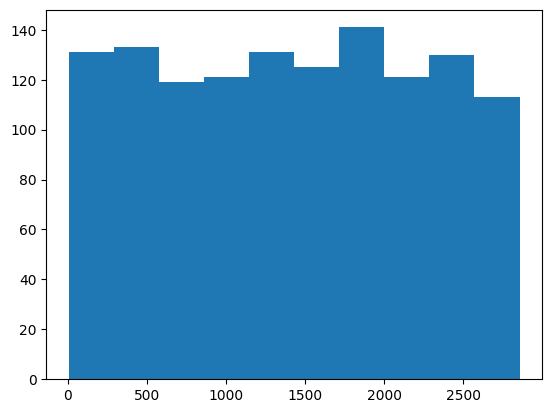

In [146]:
from matplotlib import pyplot as plt
plt.hist(df.text_length)

<BarContainer object of 5 artists>

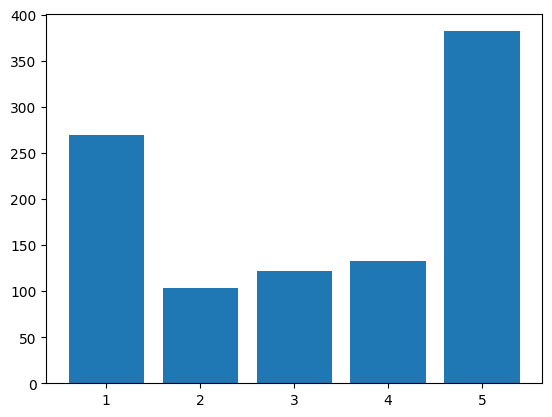

In [148]:
val_counts = df.rating.value_counts()
plt.bar(val_counts.index, val_counts.values)

In [156]:
# from pprint import pprint
error_counts

{'truncated': 0, 'jsonerror': 83, 'control_char': 0, 'bom': 23}

In [ ]:
out = {
    "rows_parsed": int(len(df)),
    "error_counts": {k:int(v) for k,v in error_counts.items()},
    "rating_hist": ratings_hist,
    "p95_text_length": int(p95_text_length),
    "empty_text_count": int(empty_text_count)
}
out

{'rows_parsed': 1266,
 'error_counts': {'truncated': 0,
  'jsonerror': 83,
  'control_char': 0,
  'bom': 23},
 'rating_hist': {5.0: np.int64(382),
  1.0: np.int64(269),
  4.0: np.int64(133),
  3.0: np.int64(122),
  2.0: np.int64(103)},
 'p95_text_length': 2673,
 'empty_text_count': 1}

In [158]:
p95_text_length

np.float64(2673.7999999999997)